# [Computational Social Science] Project 4: Unsupervised Learning

**Brenda Sciepura

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [562]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [563]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

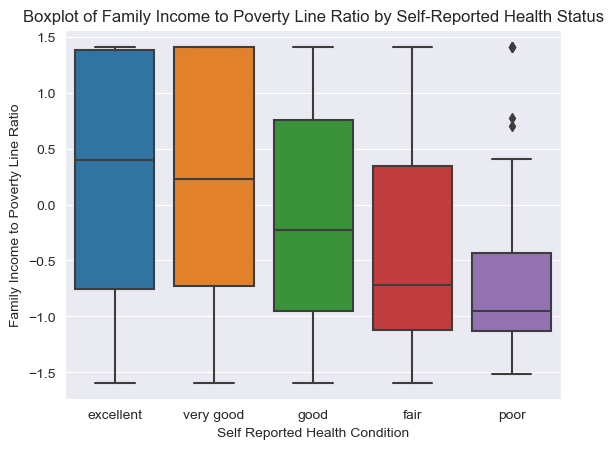

In [564]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

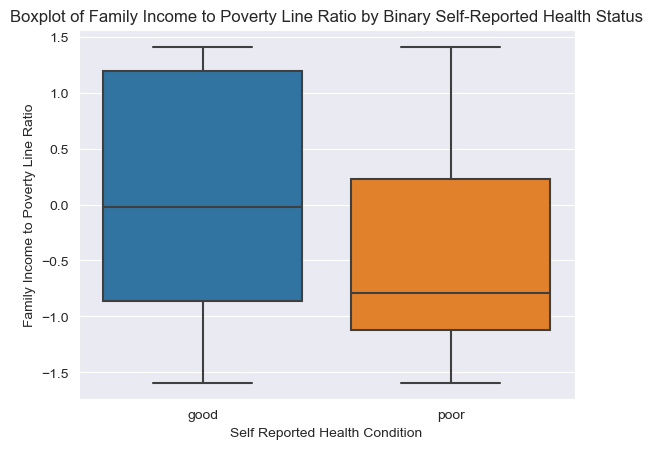

In [565]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

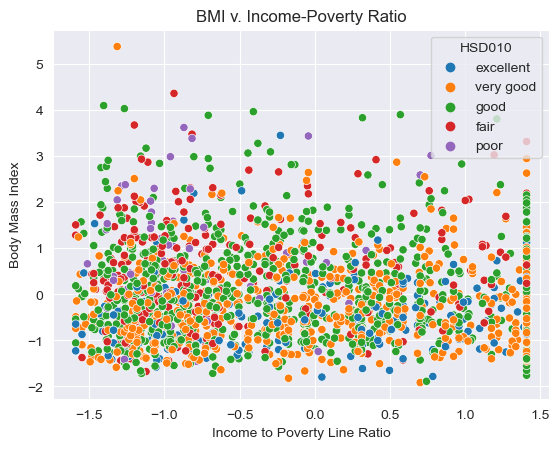

In [566]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [567]:
nhanes_scaled_nt = nhanes_scaled.drop(['HSD010_binary', 'HSD010'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

First I train the PCA with no pre-selection of the number of components to analyze what would be the appropriate choice based on a scree plot. 

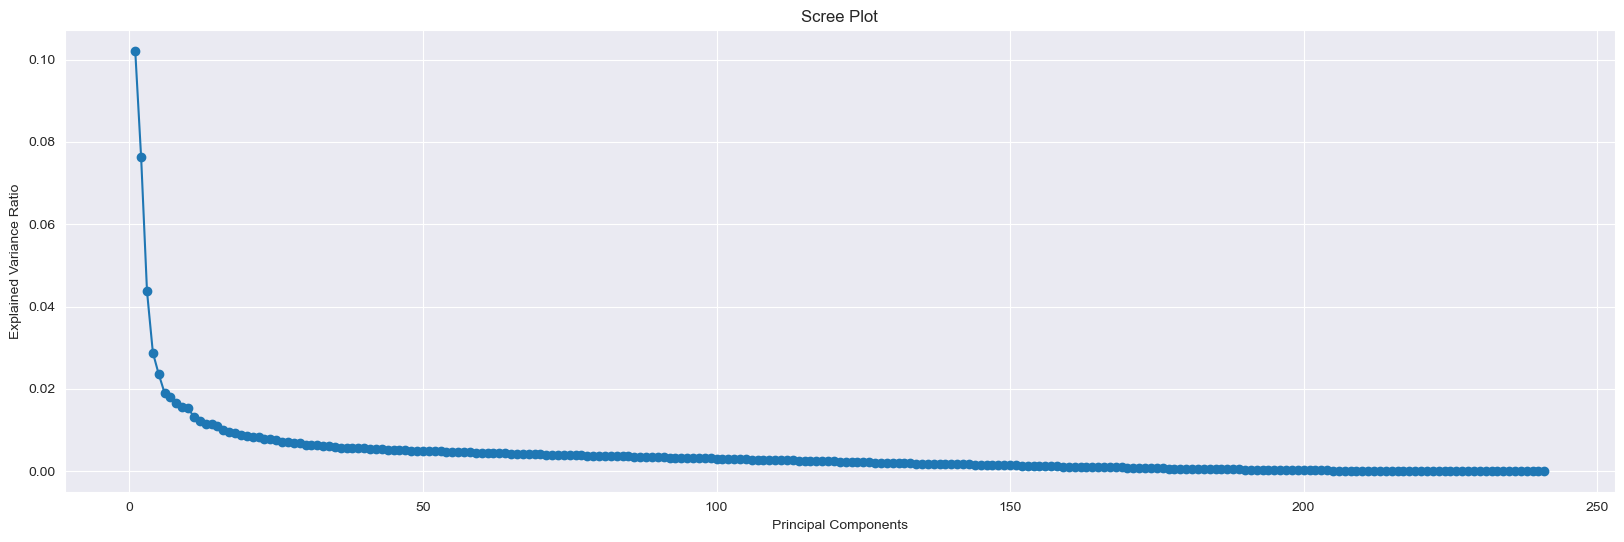

In [568]:
# create scree plot from PCA fit
# ----------
pca = PCA()
pca.fit(nhanes_scaled_nt)

# Scree plot
plt.figure(figsize=(20, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

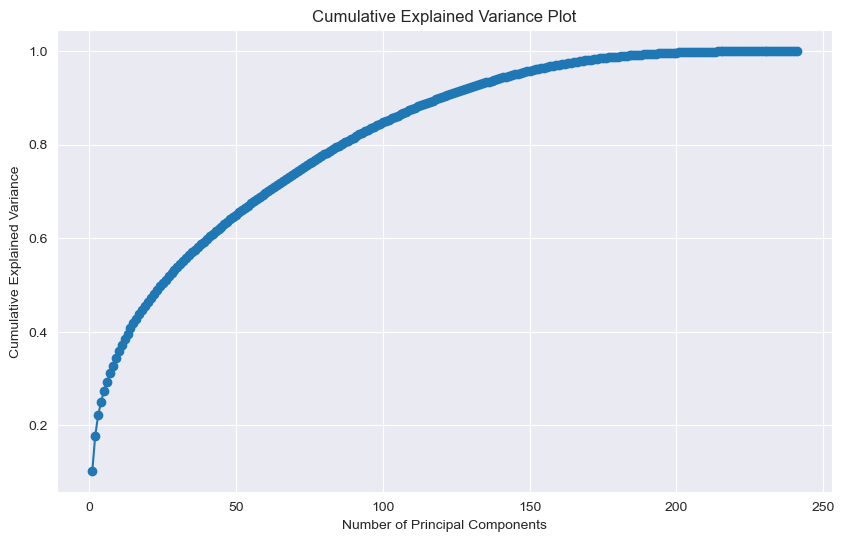

In [569]:
# Cumulative explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Number of components: I'm choosing 10 components based on the scree plot. However, the cumulative explained variance plot is confusing to me, because if I wanted to capture ~80/90% variance, this implies using over 100 features, which doesn't really align with the scree plot. I choose 100 features below when I fit the supervised model. So I'm picking ten here though in reality I should probably work with a much larger number. In the barpot below, where we plot 10 components, we see that even though the explained variance differs among them, it's significant for all of them. 

### Barplot of Components

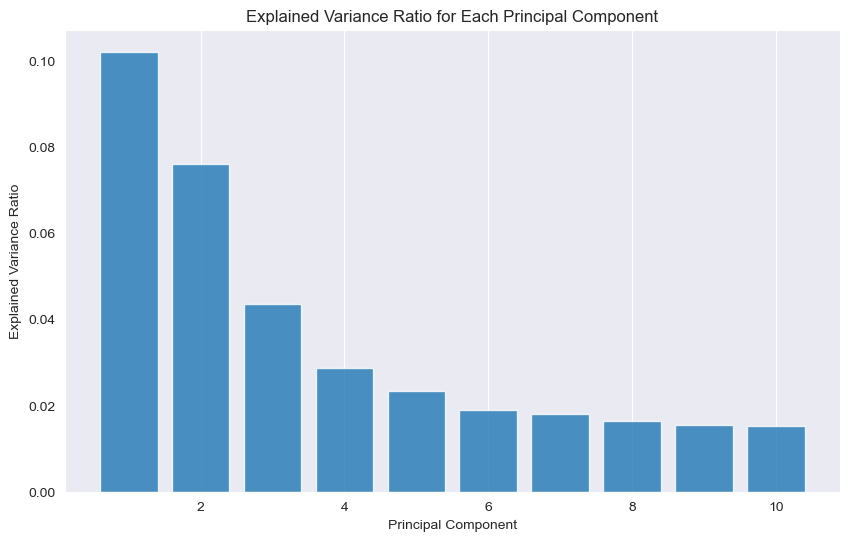

In [570]:
pca = PCA(n_components=10)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_nt)

# Extract the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center', alpha=0.8)
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(axis='y')

plt.show()

### How many components will you use to fit a supervised learning model?

## Your Answer Here

Re-valuating number of components: I'm choosing 100 components to fit a supervised learning model. 

In [571]:
# apply PCA
# ----------
pca = PCA(n_components=100)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_nt)

pca_df = pd.DataFrame(data = principalComponents_nhanes, index=nhanes_scaled_nt.index)  

# view factor loadings as dataframe
pca_df.head()

# view factor loadings as dataframe
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,9.527812,-0.816225,-1.867105,-2.109853,-3.929392,-0.185257,-3.845281,-2.935281,1.513337,0.683581,...,-0.332781,-0.594502,-0.072281,1.092643,0.931931,-0.101491,1.336703,-0.683523,-0.175015,-1.281718
73576,-5.838339,-3.692575,3.805754,-1.029645,0.394745,1.592790,2.710833,-0.741655,0.385457,-2.407928,...,-1.280273,5.704672,-0.647447,-0.245119,3.160840,-0.738478,-0.464611,0.469916,0.786777,-1.899518
73579,-0.719454,-2.573200,0.907909,-4.755861,-1.798838,0.863435,-1.024432,0.633161,0.541812,0.449139,...,0.472448,0.499478,-0.079919,-0.612890,0.070138,0.618791,-1.061270,0.211691,-0.554115,0.078494
73581,3.533627,-2.576982,-3.249123,-0.405422,3.999088,1.444339,-1.182281,0.326742,-4.151363,-1.246130,...,0.642274,0.450177,-0.863103,0.149636,-0.130887,-0.541397,-0.990313,-0.221555,-0.159991,-0.027588
73584,-6.872094,-4.194241,0.886812,-0.848915,-0.524846,0.072674,0.843466,0.988421,0.555596,-0.046049,...,-0.425528,0.211192,0.389951,-2.025416,-0.304149,-0.835232,0.964954,-0.825721,-0.269646,-0.563466


In [572]:
## outcome variable to do following plots 
pca_df['HSD010_binary'] = nhanes_scaled['HSD010_binary']

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

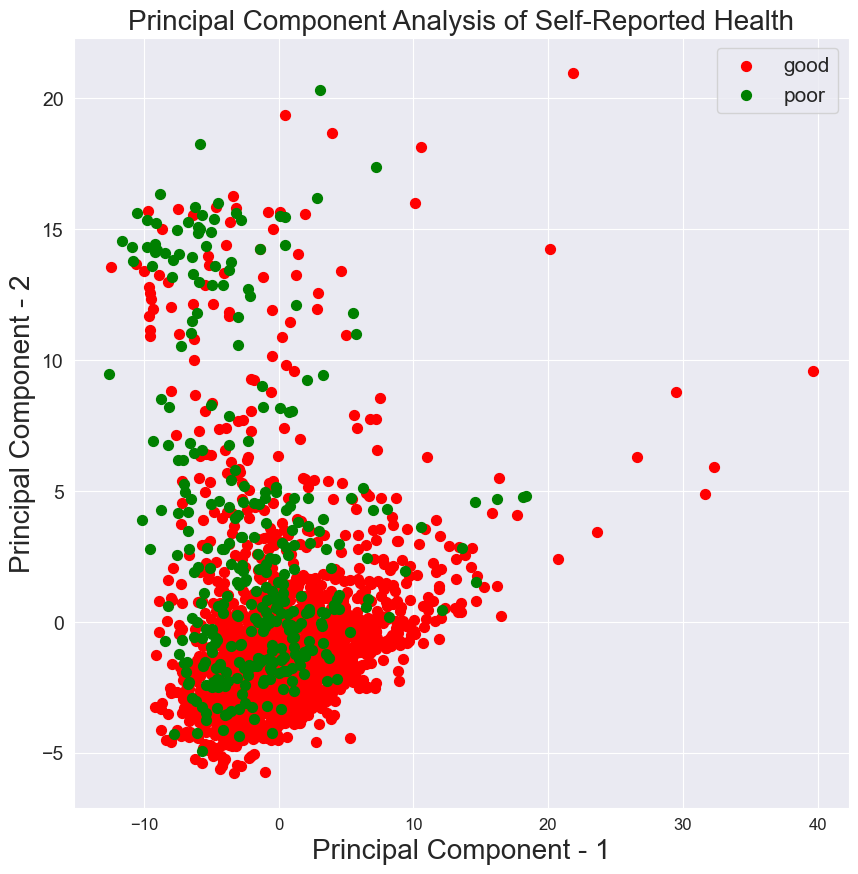

In [573]:
# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Self-Reported Health",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 0]
               , pca_df.loc[indicesToKeep, 1], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

Graph interpretation: This does not seem like a good fit. Component 1 and 2 overlap to a large extent, making it difficult to differentiate two groupings. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

K-Means: This method divides a dataset into k distinct, non-overlapping clusters. It aims to assign each data point to one of the clusters in a way that minimizes the within-cluster sum of squares, which is the sum of squared distances between each data point and the centroid of its assigned cluster. It's simple and easy to implement, and it scales well with the number of data points. However, you need to specify the number of clusters in advance. 

### Cluster nhanes

In [574]:
# set random seed
np.random.seed(10)

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=2,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_nt)

In [575]:
## creating the centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=nhanes_scaled_nt.columns)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [576]:
## adding the label 
nhanes_scaled_kmeans = nhanes_scaled.assign(label = kmeans.labels_.astype(str))

Text(0.5, 1.0, 'BMI v. Income-Poverty Ratio')

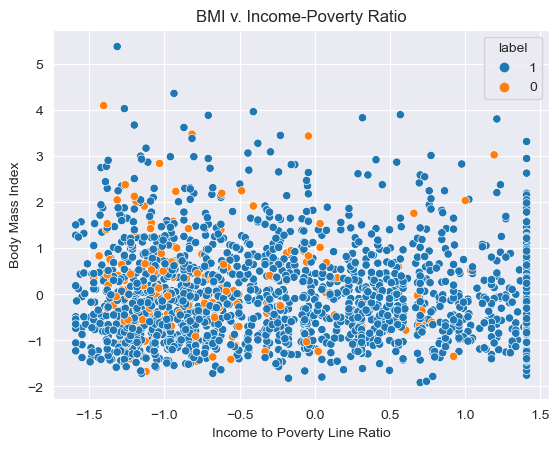

In [577]:
## plotting on top of the BMI v Income Poverty ratio plot 
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "label", palette = "tab10", data = nhanes_scaled_kmeans)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")

It is still hard to identify two distinct groups, which also makes it hard to see if there's a differential relationship between BMI and Income to Poverty Ratio between the two groups. There's not a clear relationship emerging from the plot. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [578]:
## dropping the outcome
pca_nt = pca_df.drop(columns=['HSD010_binary'])

In [579]:
# set random seed
np.random.seed(10)

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=2,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_nt)

In [580]:
## adding the label
pca_nt_kmeans = pca_nt.assign(label = kmeans.labels_.astype(str))

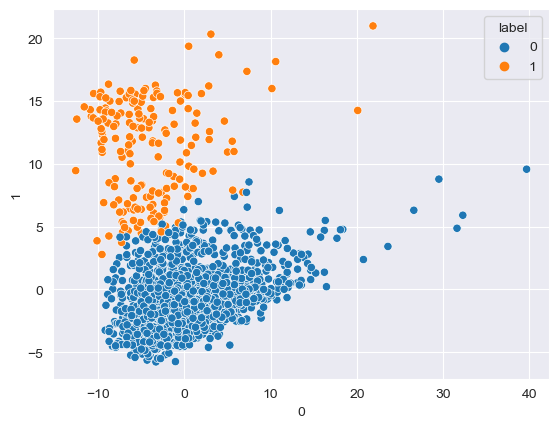

In [581]:
## plotting on top of the BMI v Income Poverty ratio plot 
ax = sns.scatterplot(x = 0, y = 1, hue = "label", palette = "tab10", data = pca_nt_kmeans)

When we substitute the plotting of the original features with the first two components generated by PCA, a striking contrast emerges from the previous graph. In this instance, the PCA-generated plot reveals the presence of two distinct groupings. This disparity arises because PCA constructs components as linear combinations of the original features, prioritizing their ability to explain variance. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [582]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [557]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary'] # either hsd010 or hsd010_binary, 
y = y.astype('category').cat.codes # converting to numeric

X = nhanes_scaled.drop(columns=['HSD010_binary', 'HSD010']) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [584]:
# create neural network model
# -----------
model_original = Sequential()

model_original.add(Dense(num_classes, input_dim= 241, kernel_initializer='normal', activation='relu'))

model_original.compile(loss='binary_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy']) 

model_original.fit(X_train,                  # specify the x data
                   y_train,                  # specify the y data
                   validation_data=(X_test,  # specify the validation data
                                    y_test), 
                   epochs=50,                # number of iterations back and forth through the network
                   batch_size=100,           # number of images it will input per batch 
                   verbose=2);   

Epoch 1/50
16/16 - 1s - loss: 4.5552 - accuracy: 0.6298 - val_loss: 4.5251 - val_accuracy: 0.6027 - 829ms/epoch - 52ms/step
Epoch 2/50
16/16 - 0s - loss: 4.1211 - accuracy: 0.6731 - val_loss: 4.1343 - val_accuracy: 0.6395 - 278ms/epoch - 17ms/step
Epoch 3/50
16/16 - 0s - loss: 3.6663 - accuracy: 0.7106 - val_loss: 3.7467 - val_accuracy: 0.6531 - 243ms/epoch - 15ms/step
Epoch 4/50
16/16 - 0s - loss: 3.2666 - accuracy: 0.7209 - val_loss: 3.4010 - val_accuracy: 0.6764 - 102ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 2.9794 - accuracy: 0.7293 - val_loss: 3.1870 - val_accuracy: 0.6957 - 111ms/epoch - 7ms/step
Epoch 6/50
16/16 - 0s - loss: 2.7901 - accuracy: 0.7410 - val_loss: 2.8724 - val_accuracy: 0.7054 - 156ms/epoch - 10ms/step
Epoch 7/50
16/16 - 0s - loss: 2.6784 - accuracy: 0.7519 - val_loss: 2.7225 - val_accuracy: 0.7229 - 120ms/epoch - 8ms/step
Epoch 8/50
16/16 - 0s - loss: 2.5390 - accuracy: 0.7603 - val_loss: 2.6707 - val_accuracy: 0.7229 - 193ms/epoch - 12ms/step
Epoch 9/50


In [585]:
# Evaluate the model on the test set
loss, accuracy = model_original.evaluate(X_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

17/17 [==============================] - 0s 3ms/step - loss: 2.1503 - accuracy: 0.7888
Test Loss: 2.1503
Test Accuracy: 0.7888


### Neural Network on Principal Components

In [586]:
# partition data
# -----------
y = pca_df['HSD010_binary'] # either hsd010 or hsd010_binary
y = y.astype('category').cat.codes # converting to numeric 

X = pca_nt # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [589]:
# create neural network model
# -----------
model_pca = Sequential()

model_pca.add(Dense(num_classes, input_dim= 100, kernel_initializer='normal', activation='relu'))

model_pca.compile(loss='binary_crossentropy',   # specify the loss function
                  optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
                  metrics=['accuracy']) 

model_pca.fit(X_train,                  # specify the x data
              y_train,                  # specify the y data
              validation_data=(X_test,  # specify the validation data
                               y_test), 
              epochs=50,                 # number of iterations back and forth through the network
              batch_size=100,           # number of images it will input per batch 
              verbose=2); 

Epoch 1/50
16/16 - 1s - loss: 4.6081 - accuracy: 0.5730 - val_loss: 4.7699 - val_accuracy: 0.5911 - 659ms/epoch - 41ms/step
Epoch 2/50
16/16 - 0s - loss: 4.4211 - accuracy: 0.5859 - val_loss: 4.7240 - val_accuracy: 0.5930 - 87ms/epoch - 5ms/step
Epoch 3/50
16/16 - 0s - loss: 4.2966 - accuracy: 0.6021 - val_loss: 4.4868 - val_accuracy: 0.6027 - 140ms/epoch - 9ms/step
Epoch 4/50
16/16 - 0s - loss: 4.1471 - accuracy: 0.6150 - val_loss: 4.3303 - val_accuracy: 0.6240 - 154ms/epoch - 10ms/step
Epoch 5/50
16/16 - 0s - loss: 4.0319 - accuracy: 0.6292 - val_loss: 4.1944 - val_accuracy: 0.6434 - 93ms/epoch - 6ms/step
Epoch 6/50
16/16 - 0s - loss: 3.9320 - accuracy: 0.6395 - val_loss: 4.1092 - val_accuracy: 0.6628 - 88ms/epoch - 6ms/step
Epoch 7/50
16/16 - 0s - loss: 3.8104 - accuracy: 0.6512 - val_loss: 4.0833 - val_accuracy: 0.6705 - 88ms/epoch - 5ms/step
Epoch 8/50
16/16 - 0s - loss: 3.7169 - accuracy: 0.6615 - val_loss: 4.0187 - val_accuracy: 0.6841 - 90ms/epoch - 6ms/step
Epoch 9/50
16/16 - 

In [590]:
# Evaluate the model on the test set
loss, accuracy = model_pca.evaluate(X_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

17/17 [==============================] - 0s 2ms/step - loss: 2.3527 - accuracy: 0.7481
Test Loss: 2.3527
Test Accuracy: 0.7481


### Neural Network on Principal Components + Cluster Membership

In [591]:
# partition data
# -----------
y = pca_df['HSD010_binary'] # either hsd010 or hsd010_binary
y = y.astype('category').cat.codes # converting to numeric

## adding cluster membership 
pca_feature_label = pca_nt.join(nhanes_scaled_kmeans[['label']], how='inner')

X = pca_feature_label # drop out any columns that aren't features
X['label'] = X['label'].astype('category').cat.codes ## converting label to numeric 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [592]:
# create neural network model
# -----------
model_pca_cluster = Sequential()

model_pca_cluster.add(Dense(num_classes, input_dim= 101, kernel_initializer='normal', activation='relu'))

model_pca_cluster.compile(loss='binary_crossentropy',   # specify the loss function
                          optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
                          metrics=['accuracy']) 
            
model_pca_cluster.fit(X_train,                  # specify the x data
                      y_train,                  # specify the y data
                      validation_data=(X_test,  # specify the validation data
                                       y_test), 
                      epochs=50,                 # number of iterations back and forth through the network
                      batch_size=100,           # number of images it will input per batch 
                      verbose=2); 

Epoch 1/50
16/16 - 1s - loss: 4.3976 - accuracy: 0.6609 - val_loss: 4.4986 - val_accuracy: 0.6705 - 735ms/epoch - 46ms/step
Epoch 2/50
16/16 - 0s - loss: 4.1750 - accuracy: 0.6848 - val_loss: 4.3721 - val_accuracy: 0.6667 - 93ms/epoch - 6ms/step
Epoch 3/50
16/16 - 0s - loss: 4.0322 - accuracy: 0.6996 - val_loss: 4.2251 - val_accuracy: 0.6725 - 91ms/epoch - 6ms/step
Epoch 4/50
16/16 - 0s - loss: 3.9477 - accuracy: 0.7003 - val_loss: 4.1791 - val_accuracy: 0.6647 - 101ms/epoch - 6ms/step
Epoch 5/50
16/16 - 0s - loss: 3.8050 - accuracy: 0.7028 - val_loss: 4.0819 - val_accuracy: 0.6705 - 81ms/epoch - 5ms/step
Epoch 6/50
16/16 - 0s - loss: 3.6845 - accuracy: 0.7106 - val_loss: 3.9917 - val_accuracy: 0.6705 - 83ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 3.5688 - accuracy: 0.7183 - val_loss: 3.8859 - val_accuracy: 0.6725 - 82ms/epoch - 5ms/step
Epoch 8/50
16/16 - 0s - loss: 3.4656 - accuracy: 0.7222 - val_loss: 3.7799 - val_accuracy: 0.6686 - 86ms/epoch - 5ms/step
Epoch 9/50
16/16 - 0s

In [593]:
# Evaluate the model on the test set
loss, accuracy = model_pca_cluster.evaluate(X_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

17/17 [==============================] - 0s 2ms/step - loss: 1.5193 - accuracy: 0.8217
Test Loss: 1.5193
Test Accuracy: 0.8217


The PCA + Clustering model worked best, with the highest accuracy score of 0.82 (pca = 0.74 and original features =0.78) and the lowest loss of 1.51 (pca = 2.35, original features = 2.15). I would pick the PCA + Clustering model. It seems that the dimension reduction (given that the original data has so many columns) resulted in a cleaner representation of the data, making it easier for the neural network to learn meaningful patterns. Additionally, clusters can serve as informative features for training a neural network, allowing it to leverage the intrinsic structure of the data.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA and clustering are both techniques used in the field of unsupervised learning, but they serve different purposes.

** PCA has two goals: 1) Reduce number of dimensions by transforming the original features into a set of uncorrelated variables called principal components that are linear combinations of the original features, 2) Capture as much variance as possible in the data. 

** Clustering aims to group similar data points together baed on some similarity measure. The goal is to discover natural groupings in the data based on certain characteristics. Each created cluster represents a group of similar observations. 

We can use PCA before applying clustering techniques because first reducing the dimensionality with PCA can help in dealing with the curse of dimensionality and can enhance the performance of clustering algorithms. We can use PCA to visualize high-dimensional data in a lower-dimensional space, and then use clustering to observe whether there are any natural patterns or groupings in this already reduced space.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Yes, the graph of component 1 and 2 was able to clearly see two distinct groupings. This is because by using PCA and clustering combined I'm first reducing the number of dimensions but keeping the ones with highest variance, which then combined with clustering makes it easier to identified groups with similar behavior. By retaining through PCA the components with the most variance, it helps filter out noise and irrelevant information. Additionally, by capturing the most significant sources of variation, PCA can enhance the separation between clusters.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised models can help managing the curse of dimensionality: The reduced set of principal components can be used as input for a supervised model, speeding up training and improving efficiency without sacrificing much information. By doing this it can also improve overfitting. 

Unsupervised models can produce new information that supervised models can take into account to improve predictions. For instance, clustering can reveal natural groupings. The cluster assignments can be used as new features for a supervised model, capturing inherent patterns structures in the data that can serve as input for prediction.

Unsupervised models can detect data anomalies which is valuable for improving data quality in the context of big data before applying supervised methods. DBSCAN, for example, excels at identifying dense regions and spotting anomalies, such as areas that don't fit into any cluster or form small clusters. Ensuring quality through anomaly detection becomes particularly essential for large datasets, acting as a critical step in quality control.